In [1]:
!pip install 'h5py==2.10.0' --force-reinstall
!pip install ISR 

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 15.7 MB 36.4 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

     |████████████████████████████████| 86.3 MB 47 kB/s 
     |████████████████████████████████| 3.8 MB 35.5 MB/s 
     |████████████████████████████████| 449 kB 38.8 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f07481aae50a21677815bf57d915bc43a19f25eb7150358169913dd9da5e2f66
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Success

In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
!wget http://images.math.cnrs.fr/IMG/png/section8-image.png
!mkdir -p data/input/test_images
!mv *.png data/input/test_images

--2022-03-13 05:48:28--  http://images.math.cnrs.fr/IMG/png/section8-image.png
Resolving images.math.cnrs.fr (images.math.cnrs.fr)... 134.206.83.12
Connecting to images.math.cnrs.fr (images.math.cnrs.fr)|134.206.83.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114590 (112K) [image/png]
Saving to: ‘section8-image.png’

section8-image.png  100%[===================>] 111.90K   362KB/s    in 0.3s    

2022-03-13 05:48:28 (362 KB/s) - ‘section8-image.png’ saved [114590/114590]



In [14]:
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O data/input/test_images/original.png

--2022-03-13 05:50:24--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolving lh4.googleusercontent.com (lh4.googleusercontent.com)... 74.125.132.132, 2607:f8b0:4001:c00::84
Connecting to lh4.googleusercontent.com (lh4.googleusercontent.com)|74.125.132.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84897 (83K) [image/jpeg]
Saving to: ‘data/input/test_images/original.png’

data/input/test_ima 100%[===================>]  82.91K  --.-KB/s    in 0.001s  

2022-03-13 05:50:24 (63.8 MB/s) - ‘data/input/test_images/original.png’ saved [84897/84897]



Load the image with PIL

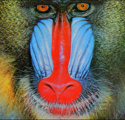

In [15]:
import numpy as np
from PIL import Image

img = Image.open('data/input/test_images/sample.png')
img

In [16]:
from ISR.models import RDN, RRDN

model = RRDN(weights='gans')

#### Baseline

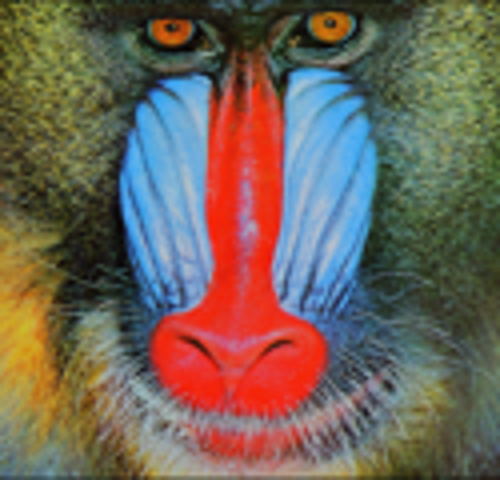

In [17]:
img.resize(size=(img.size[0]*4, img.size[1]*4), resample=Image.BICUBIC)

In [25]:
IMAGE_PATH = "data/input/test_images/original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [42]:
def preprocess_image(image_path):
 
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("data/output/%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [27]:
def plot_image(image, title=""):

  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [28]:
hr_image = preprocess_image(IMAGE_PATH)#### Prediction

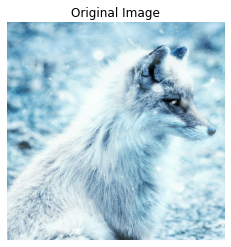

In [44]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")

In [ ]:
model1 = hub.load(SAVED_MODEL_PATH)

In [31]:
start = time.time()
fake_image = model1(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 82.210056


Saved as RestoredImage.jpg


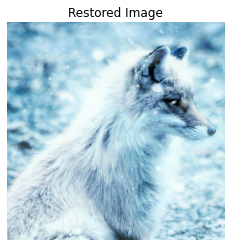

In [46]:
plot_image(tf.squeeze(fake_image), title="Restored Image")
save_image(tf.squeeze(fake_image), filename="RestoredImage")

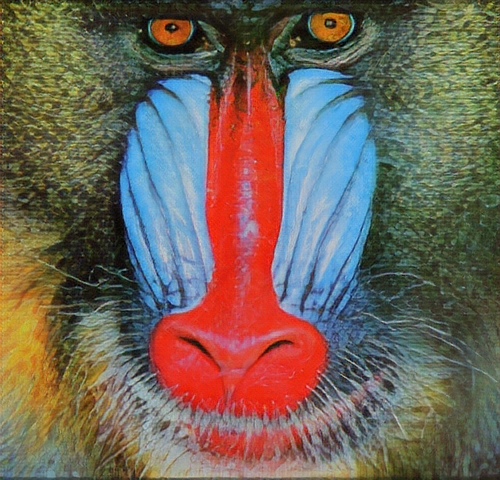

In [33]:
sr_img = model.predict(np.array(img))
Image.fromarray(sr_img)

### Usecase: upscaling noisy images

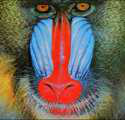

In [34]:
img.save('data/input/test_images/compressed.jpeg','JPEG', dpi=[300, 300], quality=50)
compressed_img = Image.open('data/input/test_images/compressed.jpeg')

compressed_img

#### Baseline

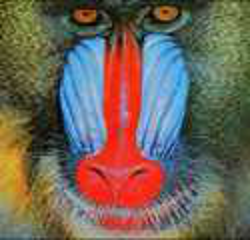

In [35]:
compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)

66076672/66071288 [==============================] - 4s 0us/step


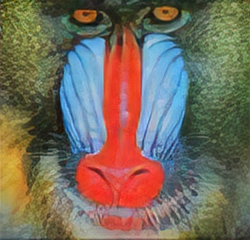

In [36]:
model = RDN(weights='noise-cancel')
sr_img = model.predict(np.array(compressed_img))
Image.fromarray(sr_img)

#Demo

Noisy Image

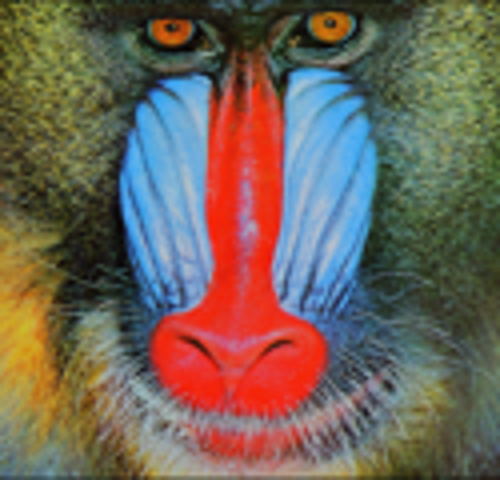

In [64]:
img = Image.open('data/input/test_images/sample.png')
img.resize(size=(img.size[0]*4, img.size[1]*4), resample=Image.BICUBIC)

Restored Image

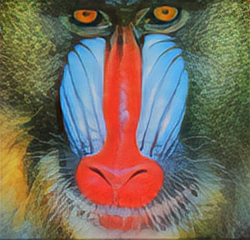

In [65]:
restored_image = model.predict(np.array(img))
Image.fromarray(restored_image)

Save Restored Image

In [66]:
save_image(tf.squeeze(fake_image), filename="RestoredSampleImage")

Saved as RestoredSampleImage.jpg
